## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for **75%** of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling


### Mounting google drive
In the below section, we will mount the Google drive location, where we have stored the images

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Defining the Train and the Test data location

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/My Drive/UpGrad/Melanoma/Data/Train/")
data_dir_test = pathlib.Path('gdrive/My Drive/UpGrad/Melanoma/Data/Test/')

### Train and the Test image count

In [29]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Defining the Batch size and the Image size

In [5]:
batch_size = 32
img_height = 180
img_width = 180

## Train and Validation Dataset creation
In the below 2 sections, we will create the Train and the validation datasets. Sinc the folder is structured with the class names, we will use the image_dataset_from_directory function to import data from Train dataset. 
We will use the same train data to split into Train and Validation dataset.
We will have a split of 80:20 for Train:Validation dataset

In [6]:
train_ds = preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', color_mode='rgb', batch_size=batch_size, validation_split=0.2,
  subset="training",label_mode='int', image_size=(img_height, img_width), shuffle=True, seed=123, interpolation='bilinear')


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', color_mode='rgb', batch_size=batch_size, validation_split=0.2,
  subset="validation",label_mode='int', image_size=(img_height, img_width), shuffle=True, seed=123, interpolation='bilinear')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Derive list of class names

In [32]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
def batch_normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_x_norm = train_ds.map(batch_normalize)
val_x_norm = val_ds.map(batch_normalize)

## Visualization
We will plot the images for each of the classes using Matplot lib.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

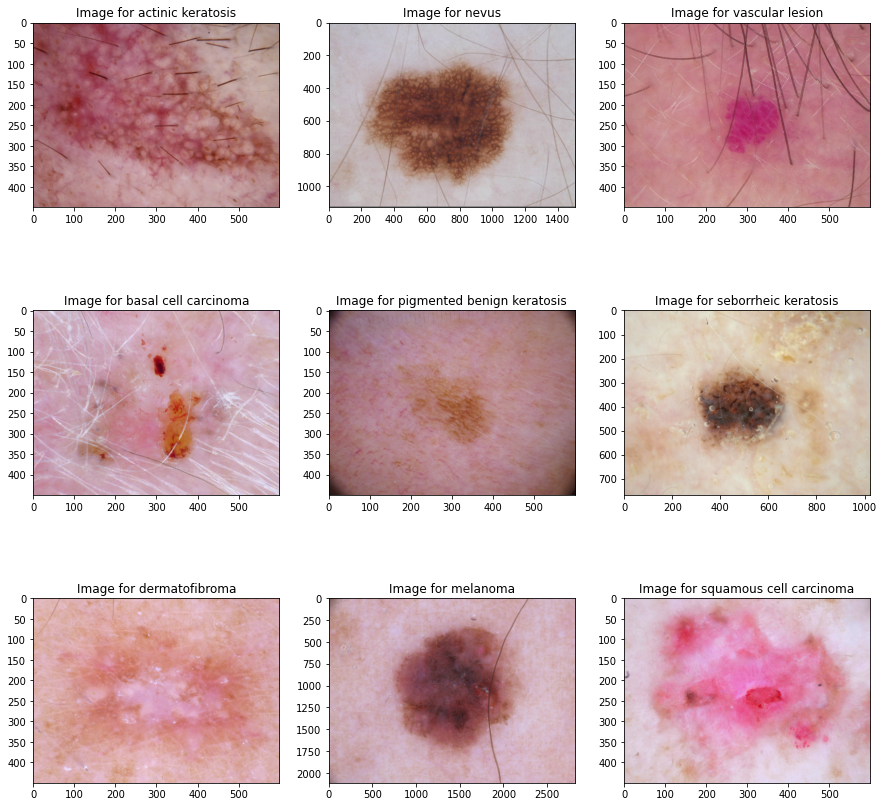

In [ ]:
fig, axis = plt.subplots(3,3,figsize=(15, 15))

for i, cls in enumerate(class_names):
  pth = os.path.join(data_dir_train,cls)
  fl_name =os.path.join(pth,os.listdir(pth)[0])
  img = mpimg.imread(fl_name)
  axis[(i-(i//3))%3,i//3].imshow(img)
  axis[(i-(i//3))%3,i//3].set(title="Image for "+cls)
plt.show()




### Performance optimization
We will use the **cache** feature to keep the images in memory after they're loaded off disk during the first epoch. Also, we will use the **prefetch** feature which overlaps data preprocessing and model execution while training

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building
We will use a model of type **sequential** to solve the above classification problem. The sequential model that i have designed contains of close to **6 convolution layers**, starting with 128, 64, 32 number of filters. Each of these filters is of size **3*3**. Following every Convolution layer is an **activation layer**, whose activation function is **relu**. After every 2 successive convolution layer, we will have a **MaxPooling** layer of size **2*2**.
After we are done with the Convolution layers, we wil flatten the weght matrix and perform **2** sets of **Dense** layers. The last dense layer has a 9 parameters in its output layers, signfying the **9 classes**. The activation of the last layer is **softmax** as its a multi-class classification problem. 
We will also use the **Rescaling** function to scale the images so that their value id between 0 and 1.

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180,180,3)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

## Model Summary
Below we can see that there are a total of **21 layers** and a total of **1,929,289 trainable parameters**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 128)     3584      
                                                                 
 activation (Activation)     (None, 180, 180, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 128)     147584    
                                                                 
 activation_1 (Activation)   (None, 178, 178, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 128)      0         
 )                                                               
                                                        

## Model Compilation
As part of the model compilation, we will use the **Stochastic Gradient Descent** optimizer with the **Learning rate set to 0.005**. We will also use the **SparseCategoricalCrossentropy** as the loss function and the **accuracy** as the evalation metrics.

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.005)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

## Model Training
We will train the models with epcohs value set to 20.

In [ ]:
epochs = 20
history = model.fit(
  train_ds, #train_x_norm,
  validation_data=val_ds, #val_x_norm,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 258ms/step - loss: 1.7879 - accuracy: 0.3616 - val_loss: 1.6493 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 14s 256ms/step - loss: 1.7796 - accuracy: 0.3555 - val_loss: 1.6431 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 14s 258ms/step - loss: 1.7291 - accuracy: 0.3717 - val_loss: 2.2809 - val_accuracy: 0.2282
Epoch 4/20
56/56 [==============================] - 14s 258ms/step - loss: 1.7229 - accuracy: 0.3890 - val_loss: 1.6927 - val_accuracy: 0.3758
Epoch 5/20
56/56 [==============================] - 14s 256ms/step - loss: 1.7254 - accuracy: 0.3834 - val_loss: 1.7295 - val_accuracy: 0.3758
Epoch 6/20
56/56 [==============================] - 14s 256ms/step - loss: 1.7169 - accuracy: 0.3962 - val_loss: 1.5607 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 14s 255ms/step - loss: 1.7081 - accuracy: 0.3834 - val_loss: 1.7685 - val_accuracy: 0.3468

## Model Performance visualization
We will use the below matplotlib to visualize the accuracy and the loss of the model. 

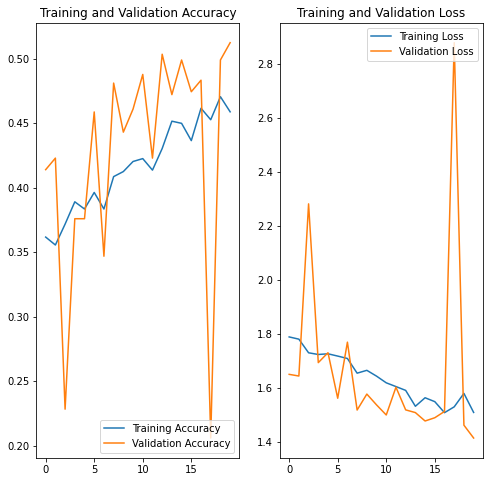

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Performance Analysis
From the above plot, we can see that the training accuracy increase gradually with passing epochs, but there are major spikes in the validation accuracy. In most of the cases is validation accuracy is higher than Training accuracy. This shows that there is an element of **underfitting**. Also, the loss of the validation dataset on an average is lesser than the training dataset.
In the next section we will try to build the model with the **dropout feature** enabled

## Model development with dropout

In [ ]:
model_d = Sequential()
model_d.add(Rescaling(1./255, input_shape=(180,180,3)))
model_d.add(Conv2D(128, (3, 3), padding='same'))
model_d.add(Activation('relu'))
model_d.add(Conv2D(128, (3, 3)))
model_d.add(Activation('relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.25))

model_d.add(Conv2D(64, (3, 3), padding='same',input_shape=(180,180,3)))
model_d.add(Activation('relu'))
model_d.add(Conv2D(64, (3, 3)))
model_d.add(Activation('relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.25))

model_d.add(Conv2D(32, (3, 3), padding='same'))
model_d.add(Activation('relu'))
model_d.add(Conv2D(32, (3, 3)))
model_d.add(Activation('relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.25))

model_d.add(Flatten())
model_d.add(Dropout(0.5))
model_d.add(Dense(128))
model_d.add(Activation('relu'))
model_d.add(Dense(9))
model_d.add(Activation('softmax'))

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.005)
model_d.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
epochs = 20
history = model_d.fit(
  train_ds, #train_x_norm,
  validation_data=val_ds, #val_x_norm,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 254ms/step - loss: 1.8598 - accuracy: 0.3108 - val_loss: 1.7960 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 14s 255ms/step - loss: 1.8373 - accuracy: 0.3248 - val_loss: 1.7350 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 14s 256ms/step - loss: 1.8042 - accuracy: 0.3449 - val_loss: 1.8305 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 14s 259ms/step - loss: 1.8019 - accuracy: 0.3398 - val_loss: 2.0813 - val_accuracy: 0.2617
Epoch 5/20
56/56 [==============================] - 15s 260ms/step - loss: 1.7705 - accuracy: 0.3622 - val_loss: 1.7355 - val_accuracy: 0.3647
Epoch 6/20
56/56 [==============================] - 15s 261ms/step - loss: 1.7463 - accuracy: 0.3532 - val_loss: 1.6447 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 15s 262ms/step - loss: 1.7430 - accuracy: 0.3610 - val_loss: 1.6567 - val_accuracy: 0.3803

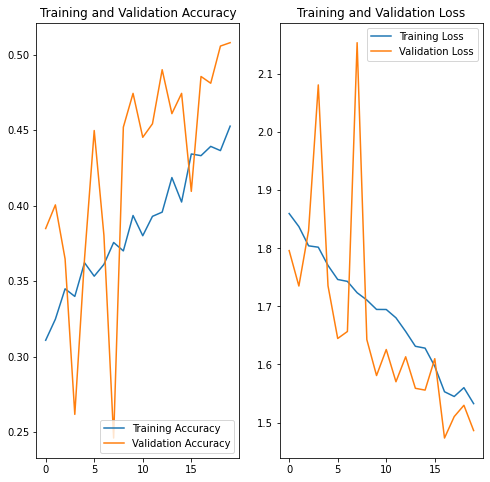

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Adding dropout layer din help much with the underfitting. The accuracy with and without dropout is the same

## Class imbalance
In the below section, we will analyze the data distribution across all the 9 classes. 


In [8]:
train_label=list(map(lambda x: x[1], train_ds))
val_label=list(map(lambda x: x[1], val_ds))

In [9]:
# Function to generate a dictionary of class count
def class_dict(label_list):
  temp_lst = []
  for i in label_list:
    temp_lst.extend(i.numpy())
  count_dict = {x:temp_lst.count(x) for x in set(temp_lst)}
  return count_dict

train_class_count = class_dict(train_label)
val_class_count = class_dict(val_label)

In [12]:
print(val_class_count)

{0: 22, 1: 67, 2: 18, 3: 86, 4: 80, 5: 92, 6: 19, 7: 39, 8: 24}


Code to plot the class distribution in both train and validation dataset

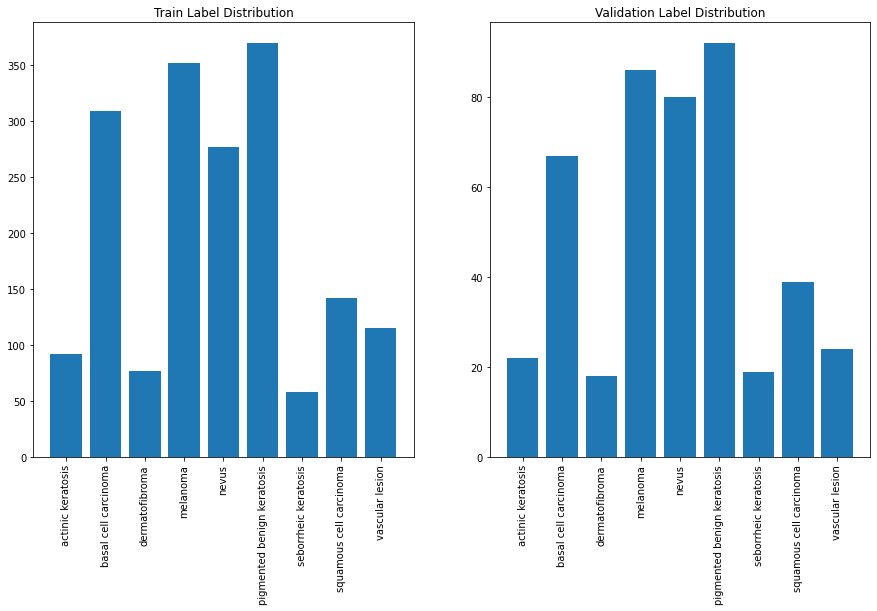

In [36]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.bar(range(len(train_class_count)), train_class_count.values(), tick_label=class_names)
plt.xticks(rotation=90)
plt.title("Train Label Distribution")
plt.subplot(1, 2, 2)
plt.bar(range(len(val_class_count)), val_class_count.values(), tick_label=class_names)
plt.xticks(rotation=90)
plt.title("Validation Label Distribution")
plt.show()

### Class Imbalance analysis
From the above graph and analysis, we see that there is a lot of imbalance in the data distribution across all the **9 classes**.
For classes like **actinic keratosis, dermatofibroma, seborrheic keratosis** have substantially less number of classes. This will lead to a scenario wherein we will have a major class imbalance.

#### Class that has least number of sample
As per the above graph we find that **seborrheic keratosis** has least number of samples all together

#### Class that dominates the data in terms proportionate number of samples
As per the above graph we find that **pigmented benign keratosis** dominates the data in terms proportionate number of samples

One way to overcome this is **Data Augmentation**. Data Augmentation is technique of fabricating new images/data from existing images/data by tweeking the alignment or image intensity.One of the python package used for this is the **Augmentor**. 

Using Augmentor, we will generate around 500 samples for each class. This will reduce the effects of class significantly.

In [41]:
## Code to generate augmented images
!pip install Augmentor
import Augmentor
path_to_training_dataset="gdrive/My Drive/UpGrad/Melanoma/Data/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB116CB14D0>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB119A08590>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB119ED8E90>: 100%|██████████| 500/500 [00:23<00:00, 21.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2597x2185 at 0x7FB1168D2250>: 100%|██████████| 500/500 [01:52<00:00,  4.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB1168C3950>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB116BE8E50>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB119E90D10>: 100%|██████████| 500/500 [00:50<00:00,  9.86 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB116798B50>: 100%|██████████| 500/500 [00:22<00:00, 22.57 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/UpGrad/Melanoma/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB11687DFD0>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


### Augmented image count

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


From the below set of code, we see that there are a total of **6739 images** in our training data set including the newly generated augmented images. 

In [56]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [55]:
path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_orig= [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

In [57]:
df1 = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df1.append(df2)


6739

The images generated using the Augmetor packages are placed in the **Output** folder. While generating the training and validation dataset using the **image_dataset_from_directory**, this folder structure might caause problem, and hence we will transfer the contents inside the Output folder to its respective class name folder.

The below code performs this transfer of images from **Output** folder to its respective class name folder

In [64]:
## Code to copy the augmented files to the original class name folder
import shutil
def move_files(src_fldr,dst_fldr):
  src_files = os.listdir(src_fldr)
  for fl in src_files:
    source_fl = os.path.join(src_fldr,fl)
    destination_fl = os.path.join(dst_fldr,fl)
    if os.path.isfile(source_fl):
      shutil.move(source_fl, destination_fl)

for cls in class_names:
  src_fldr = os.path.join("gdrive/My Drive/UpGrad/Melanoma/Data/Train/",cls,"output")
  dst_fldr = os.path.join("gdrive/My Drive/UpGrad/Melanoma/Data/Train/",cls)
  try:
    move_files(src_fldr,dst_fldr)
    print("Files moved successfully for "+cls+" folder")
  except Exception as e:
    print("Failed to move files from "+cls+" folder")
    print("Reason: "+e)
    continue

Files moved successfully for actinic keratosis folder
Files moved successfully for basal cell carcinoma folder
Files moved successfully for dermatofibroma folder
Files moved successfully for melanoma folder
Files moved successfully for nevus folder
Files moved successfully for pigmented benign keratosis folder
Files moved successfully for seborrheic keratosis folder
Files moved successfully for squamous cell carcinoma folder
Files moved successfully for vascular lesion folder


In [66]:
path_list_te = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list_te)

6739

In [61]:
batch_size = 32
img_height = 180
img_width = 180

## Augmented Train and Validation Dataset creation
In the below 2 sections, we will create the Train and the validation datasets which includes the augmented images. Since the folder is structured with the class names, we will use the image_dataset_from_directory function to import data from Train dataset. 
We will use the same train data to split into Train and Validation dataset.
We will have a split of 80:20 for Train:Validation dataset

In [12]:
data_dir_train="gdrive/My Drive/UpGrad/Melanoma/Data_aug/Train"
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [13]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


After running the abpve code, we find that the **Training dataset has 5392 images**, and the **Validation dataset has 1347 images**.

### Performance optimization
We will use the **cache** feature to keep the images in memory after they're loaded off disk during the first epoch. Also, we will use the **prefetch** feature which overlaps data preprocessing and model execution while training

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building
We will retain the same model as built in the previous trial (with dropout). To summarize the below model, we have around 25 layers and a total of 1,929,289 trainable parameters. Of the 25 layers, we have around 6 layers of Convoluation layer, each followed by 6 activation layers with ReLu as activation layer. We have 3 MaxPooling Layer and 3 Dropout lasyers each follwoing 2 conv layers. We have a flatten layer, 2 Dense layer, each followed by an activation layer and a dropout layer. We also have Rescaling layer to rescale the images so that their pixel value is between 0 and 1.

In [20]:
model_da = Sequential()
model_da.add(Rescaling(1./255, input_shape=(180,180,3)))
model_da.add(Conv2D(128, (3, 3), padding='same'))
model_da.add(Activation('relu'))
model_da.add(Conv2D(128, (3, 3)))
model_da.add(Activation('relu'))
model_da.add(MaxPooling2D(pool_size=(2, 2)))
model_da.add(Dropout(0.25))

model_da.add(Conv2D(64, (3, 3), padding='same',input_shape=(180,180,3)))
model_da.add(Activation('relu'))
model_da.add(Conv2D(64, (3, 3)))
model_da.add(Activation('relu'))
model_da.add(MaxPooling2D(pool_size=(2, 2)))
model_da.add(Dropout(0.25))

model_da.add(Conv2D(32, (3, 3), padding='same'))
model_da.add(Activation('relu'))
model_da.add(Conv2D(32, (3, 3)))
model_da.add(Activation('relu'))
model_da.add(MaxPooling2D(pool_size=(2, 2)))
model_da.add(Dropout(0.25))

model_da.add(Flatten())
model_da.add(Dropout(0.5))
model_da.add(Dense(128))
model_da.add(Activation('relu'))
model_da.add(Dense(9))
model_da.add(Activation('softmax'))

## Model Compilation
As part of the model compilation, we will use the **Stochastic Gradient Descent** optimizer with the **Learning rate set to 0.005**. We will also use the **SparseCategoricalCrossentropy** as the loss function and the **accuracy** as the evalation metrics.

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.005)
model_da.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

## Model Training
Since we have a larger dataset as compared to previous 2 model training activity, we will train the below model for a larger number of epochs. We will set the number of epochs as **50**.

In [23]:
epochs = 50
history = model_da.fit(
  train_ds_aug, #train_x_norm,
  validation_data=val_ds_aug, #val_x_norm,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 2.1835 - accuracy: 0.1432

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 865s 5s/step - loss: 2.1835 - accuracy: 0.1432 - val_loss: 2.1874 - val_accuracy: 0.1470
Epoch 2/50
169/169 [==============================] - 97s 568ms/step - loss: 2.1786 - accuracy: 0.1430 - val_loss: 2.1838 - val_accuracy: 0.1581
Epoch 3/50
169/169 [==============================] - 97s 568ms/step - loss: 2.1712 - accuracy: 0.1563 - val_loss: 2.1769 - val_accuracy: 0.2197
Epoch 4/50
169/169 [==============================] - 97s 567ms/step - loss: 2.1613 - accuracy: 0.1743 - val_loss: 2.1586 - val_accuracy: 0.2279
Epoch 5/50
169/169 [==============================] - 139s 815ms/step - loss: 2.1289 - accuracy: 0.2009 - val_loss: 2.1547 - val_accuracy: 0.1581
Epoch 6/50
169/169 [==============================] - 97s 568ms/step - loss: 2.0836 - accuracy: 0.2086 - val_loss: 2.1306 - val_accuracy: 0.1923
Epoch 7/50
169/169 [==============================] - 98s 569ms/step - loss: 2.0206 - accuracy: 0.2272 - val_loss: 2.1208 - val_accuracy: 0.18

## Performance Visualization

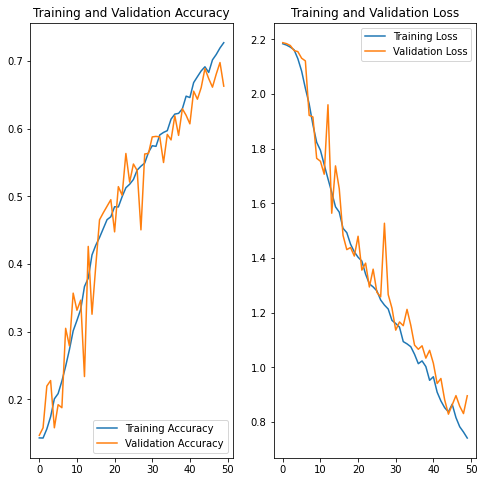

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Performance analysis
After training the model for 50 epochs, we find that the **training accuracy as well as the Validation accuracy has increased significantly**. Also **the difference between the Training accuracy and the Validation accuracy has reduced significantly**.

To summarize, the **training accuracy is around 72% and validation accuracy on an average is around 68%**. This when compared with the previous model's accuracy of 45%, is a significant raise. We have seen an **improvement of around 50%** in both training and validation accuracy.

Another thing  to notice here is that the difference in accuracy between the Training and the Valdiation dataset is very minimal. This shows that the problem or overfitting or underfitting is resolved.

## Conclusion
After performing the data augmentation activity to address both Class imbalance and training samples, we found that the accuracy improved by close to 50%. Also, the model is neither overfitting or under-fitting.